# Credit Portfolio Value Distribution

This notebook is part of the **Credit Risk Modeling** module in the MFE program at Chulalongkorn University.  
It walks through a runnable pipeline and explains each step that leads to the portfolio **value distribution**, **VaR** and **CVaR**.

---

## Roadmap
**1. Nelson–Siegel yield curves & discount factors (by rating)**  
**2. Recovery modeling via Beta MLE (by seniority)**  
**3. Rating histories → generator $ \Lambda $ → one-year transition $Q(0,1)$**  
**4. Equity–factor betas → implied asset correlation (latent normal)**  
**5. Probit thresholds from $Q$ and migration mapping**  
**6. Bond pricing under migration/default (cash-flows + discounting)**  
**7. Monte-Carlo simulation, portfolio aggregation, VaR & plots**

---

## Case Description — CreditMetrics-Style Portfolio
- **Portfolio:** 9 corporate issuers (sectors diversified), fixed-rate bullet bonds  
- **Horizon:** up to **20 years** (annual steps)  
- **Coupons:** 10% annual at period start; principal at maturity (simplified)  
- **Ratings Universe:** $\{\text{Aaa},\text{Aa},\text{A},\text{Baa},\text{Ba},\text{B},\text{Caa},\text{Ca},\text{C},\text{D}\}$ (WR removed)  
- **Recoveries:** **Beta($\alpha,\beta$)** by **seniority** (estimated from data)  
- **Dependence:** single latent **Gaussian** factor with cross-sectional correlation implied by equity–index betas  
- **Curves:** Nelson–Siegel per rating to price/discount cash flows

> **Data paths**: update the paths in the setup cell (e.g., `equity_index_data.xlsx`, rating/default tapes, recovery files).

---

## Parameters (Notebook Defaults)
- **Nelson–Siegel (cont. comp., annualized):** rating-specific $\beta_0,\beta_1,\beta_2,\tau$  
- **Transition estimation:** generator $ \Lambda $ from cleaned rating spells; $Q(0,1)=e^{\Lambda}$ (row-renormalized, WR removed)  
- **Dependence:** equity–factor **betas** $\Rightarrow$ factor covariance $\Rightarrow$ **implied correlation** matrix  
- **Recoveries:** Beta MLE per **Senior Secured / Unsecured / Subordinated** classes  
- **Simulation:** $N_\text{sims}=3{,}000$, annual steps, 9 names, horizon $=20$y

---

## Theory Recap (Key Formulas)
- **Nelson–Siegel rate:**  
  $$
  \hat r(s)=\beta_0+\beta_1\,\frac{\tau}{s}(1-e^{-s/\tau})+\beta_2\!\left[\frac{\tau}{s}(1-e^{-s/\tau})-e^{-s/\tau}\right],\qquad
  Z(0,s)=e^{-\hat r(s)\,s}.
  $$
- **Generator $\Lambda$ and one-year transition $Q$:**  
  Off-diagonals $$\lambda_{ij}=\frac{\text{\# transitions }i\to j}{\text{time in }i}$$ diagonals set so rows sum to 0; $$Q(0,1)=e^{\Lambda}$$.
- **Gaussian thresholds from $Q$:** per row (current rating $i$), transform cumulative columns to **probit**:  
  $$
  C_{i,k}=\Phi^{-1}\!\big(\text{cumprob}_{i,k}\big),\;\; \text{map latent }Z \sim \mathcal N(0,1)\text{ to next rating via bins}.
  $$
- **Pricing under migration:** coupon and principal discounted on the **next-rating** curve; if migrating to **D**, draw recovery $R \sim \text{Beta}(\alpha,\beta)$ (by seniority).
- **Value-at-Risk (VaR):** from the simulated portfolio value distribution at horizon $t$, take the $(1-\alpha)$ lower-tail quantile.

---

## Objectives
1) **Estimate** recoveries (Beta MLE), rating generator $\Lambda$, and $Q(0,1)$ from data.  
2) **Build** the latent correlation via equity–factor betas.  
3) **Derive** Gaussian thresholds and implement rating migration mapping.  
4) **Price** bonds across paths (migrations/default + recovery + rating-based discounting).  
5) **Simulate** portfolio values and **report VaR** with diagnostic plots and exportable tables.

---

> **Note:** Paths in the original scripts point to local files (e.g., `C:\Users\...`). Update the **data paths** cell before running end-to-end.


## Imports (concise)

- **pandas (pd):** tables & I/O
- **numpy (np):** arrays & numerics
- **psi:** digamma for Beta-MLE
- **minimize:** small nonlinear optimization
- **re:** regex text cleaning
- **expm:** matrix exponential (Λ → Q)
- **scipy.stats (stats):** distributions & quantiles
- **LinearRegression:** equity→factor betas (implied corr)


In [9]:
import pandas as pd
import numpy as np
from scipy.special import psi
from scipy.optimize import minimize
import re
from scipy.linalg import expm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

## Data Loading

- **Equity_ind:** Excel — equity & sector index levels used to compute weekly log-returns and estimate factor betas.
- **Recov_instru:** Tab-delimited — instrument-level recovery observations (prices) for Beta(\(\alpha,\beta\)) MLE by seniority.
- **Senior_def:** Tab-delimited — issuer default intervals (start/end) to splice into rating spells.
- **Senior_rating:** Tab-delimited — issuer rating histories (dates, labels) for generator \(\Lambda\) and \(Q(0,1)\).
- **Mast_debt:** Tab-delimited — mapping from debt instruments to issuer IDs (joins recovery to issuers).

**Seniority_str (classes):**  
`['Senior Secured Bonds', 'Senior Unsecured Bonds', 'Senior Subordi0ed Bonds', 'Subordi0ed Bonds', 'Junior Subordi0ed Bonds']`


In [2]:
Equity_ind = pd.read_excel(r"C:\My CV\Github\Credit risk modeling projects\Credit Portfolio Value Distribution\CRHW3 Data\equity_index_data.xlsx")
Recov_instru = pd.read_csv(r"C:\My CV\Github\Credit risk modeling projects\Credit Portfolio Value Distribution\CRHW3 Data\Recovery instrument data.txt",delimiter='\t')
Senior_def = pd.read_csv(r"C:\My CV\Github\Credit risk modeling projects\Credit Portfolio Value Distribution\CRHW3 Data\Senior default data.txt",delimiter='\t')
Senior_rating = pd.read_csv(r"C:\My CV\Github\Credit risk modeling projects\Credit Portfolio Value Distribution\CRHW3 Data\Senior rating data.txt",delimiter='\t')
Mast_debt = pd.read_csv(r"C:\My CV\Github\Credit risk modeling projects\Credit Portfolio Value Distribution\CRHW3 Data\MAST_DEBT.txt",delimiter='\t')
Seniority_str = ['Senior Secured Bonds', 'Senior Unsecured Bonds', 'Senior Subordi0ed Bonds', 'Subordi0ed Bonds', 'Junior Subordi0ed Bonds']

## Recovery Estimation — Map, Clean, Beta MLE

**Instrument → Issuer mapping**
- Build `issr_indices_list` by matching each `MAST_DEBT_NUM` in `Recov_instru` to rows in `Mast_debt`.
- Attach issuer IDs: `Recov_instru['MAST_ISSR_NUM'] = Mast_debt['MAST_ISSR_NUM'][issr_indices_list]`.

**Filter valid observations**
- Keep rows with nonzero `TRADING_PRICE_30_DAY_DATETIME`: `data = Recov_instru[... != '0']`.

**Per seniority class (`Seniority_str`)**
1. Loop over **unique issuers** (tracked via `seen`) to avoid double counting.
2. For each issuer in the class, compute **issuer-level mean recovery**  
   $r=\mathrm{clip}(\mathrm{TRADING\_PRICE\_30\_DAY},0.01,99.99)/100 \in (0,1)$ and append to `recov_dat_array`.
3. Let $N=\#\{r\}$. Estimate **Beta($\alpha,\beta$)** by minimizing squared residuals of the digamma system:
   $$
   \min_{\alpha,\beta>0}\;
   \Big[\overline{\ln r}-\big(\psi(\alpha)-\psi(\alpha+\beta)\big)\Big]^2
   +
   \Big[\overline{\ln(1-r)}-\big(\psi(\beta)-\psi(\alpha+\beta)\big)\Big]^2.
   $$
   Use `minimize` with bounds $\alpha,\beta \ge 10^{-3}$ and start $(1,1)$.
4. Store estimates in `alphas_array`, `betas_array`; print per class.

**Outputs**
- `alphas_array`, `betas_array`: Beta MLE parameters aligned with `Seniority_str`.

**Notes**
- Replace the final print with: `print(f"TYPE: {str_type} → α={alpha_opt:.4f}, β={beta_opt:.4f}")` (avoid using the built-in `str`).
- Guard for $N=0$ to skip empty classes.


In [3]:
issr_indices_list = []
for num in Recov_instru['MAST_DEBT_NUM']:
    issr_indices = Mast_debt[Mast_debt['MAST_DEBT_NUM'] == num].index.tolist()
    issr_indices_list.extend(issr_indices)
Recov_instru['MAST_ISSR_NUM'] = np.array(Mast_debt['MAST_ISSR_NUM'][issr_indices_list]).reshape(-1,1)
data = Recov_instru[Recov_instru['TRADING_PRICE_30_DAY_DATETIME'] != '0'];alphas_array = []; betas_array = []
for str_type in Seniority_str:
    print(f"Processing TYPE: {str_type}")
    recov_dat_array = [];seen = set()
    for num in Recov_instru['MAST_ISSR_NUM']:
        if num not in seen:
            filtered_data = data[(data['MAST_ISSR_NUM'] == num) & (data['TYPE'] == str_type)]
            seen.add(num)  # Mark as seen
            if filtered_data.empty:
                continue
            recov_dat = (filtered_data['TRADING_PRICE_30_DAY'].clip(0.01,99.99).mean()) / 100
            recov_dat_array = np.append(recov_dat,recov_dat_array)
    N = len(recov_dat_array)
    def objective(params):
        alpha, beta = params
        lhs1 = (1 / N) * np.sum(np.log(recov_dat_array))
        lhs2 = (1 / N) * np.sum(np.log(1 - recov_dat_array))
        rhs1 = psi(alpha) - psi(alpha + beta)
        rhs2 = psi(beta) - psi(alpha + beta)

        return (lhs1 - rhs1) ** 2 + (lhs2 - rhs2) ** 2

    initial_guess = [1.0, 1.0]

    result = minimize(objective, initial_guess, bounds=[(0.001, None), (0.001, None)])

    alpha_opt, beta_opt = result.x
    alphas_array = np.append(alphas_array, alpha_opt)
    betas_array = np.append(betas_array, beta_opt)
    print(f'{str}:', alpha_opt, beta_opt)

Processing TYPE: Senior Secured Bonds
<class 'str'>: 0.6973815505384654 0.6103810957872692
Processing TYPE: Senior Unsecured Bonds
<class 'str'>: 0.7129280598118616 1.3596990517950955
Processing TYPE: Senior Subordi0ed Bonds
<class 'str'>: 0.7410590844341262 2.15006965757028
Processing TYPE: Subordi0ed Bonds
<class 'str'>: 0.5215915554144366 1.2592030823550129
Processing TYPE: Junior Subordi0ed Bonds
<class 'str'>: 1.1251712317623326 12.332202773396405


## Recovery Beta–MLE Results

| Seniority                 | α        | β         | E[R] = α/(α+β) |
|--------------------------|----------|-----------|----------------|
| Senior Secured Bonds     | 0.697382 | 0.610381  | 0.533263       |
| Senior Unsecured Bonds   | 0.712928 | 1.359699  | 0.343973       |
| Senior Subordi0ed Bonds  | 0.741059 | 2.150070  | 0.256322       |
| Subordi0ed Bonds         | 0.521592 | 1.259203  | 0.292898       |
| Junior Subordi0ed Bonds  | 1.125171 | 12.332203 | 0.083610       |

**Insights**
- Clear **seniority gradient**: recoveries fall as you go down the capital structure; Junior Sub is worst.
- **Uncertainty** differs: low α+β (≈1–3) ⇒ high variance for Senior (secured/unsecured/subord.); high α+β (≈13) for Junior Sub ⇒ low but **stable** recovery near 0.
- **Portfolio impact**: low and uncertain recoveries **thicken left tails** (higher LGD, higher VaR), with Junior Sub driving the worst-case losses.

## Rating Cleaning → Generator $\Lambda$ → $Q(0,1)$ → Thresholds (concise)

**Goal.** Clean issuer rating spells with default intervals, estimate the continuous-time generator $\Lambda$, obtain one-year transitions $Q(0,1)=e^{\Lambda}$ (remove WR), and convert to Gaussian thresholds.

### Steps
1. **Normalize labels & dates**
   - Strip digits: `ISSR_RATG_TXT ← re.sub(r'\d+', '', ...)`.
   - Cast start/end to `datetime`; replace missing ends with a fixed `end_date`.

2. **Insert defaults into rating spells (per issuer)**
   - For each default interval $[s,e]$, split overlapping rating rows into cases and:
     - truncate at $s$, drop inside $[s,e]$, split across $[s,e]$, or shift starts to $e$.
   - Insert an explicit **'D'** row at the cut time.
   - Remove placeholder rows (`'-'`), and **collapse consecutive identical ratings**.

3. **Aggregate cleaned spells**
   - **Stay time** in years for each state $i$: sum of $(\text{end}-\text{start})/365.25$ across rows with rating $i$.
   - **Transition counts** $m_{ij}$: number of times a row with state $i$ is followed by state $j$ (for $i\neq j$).

4. **Generator and one-year transition**
   - Off-diagonals: $\lambda_{ij}=m_{ij}/\text{time in }i$.
   - Diagonals: $\lambda_{ii}=-\sum_{j\ne i}\lambda_{ij}$.
   - Matrix exponential: $Q(0,1)=\exp(\Lambda)$.
   - **Remove WR** row/column, then **row-renormalize** $Q$.

5. **Gaussian thresholds (upper-tail cumulation)**
   - For each row $i$, build cumulative probs by **descending** rating:
     - $F_{i,k}=\sum_{j=k}^{K-1} Q_{i,j}$, force last column to $1$.
   - Thresholds: $C_{i,k}=\Phi^{-1}(F_{i,k})$.

### Outputs
- `lamda_df`: generator $\Lambda$ (full set incl. WR).
- `Q_0_1_df`: $Q(0,1)$ with WR removed and renormalized.
- `threshold_matrix`: probit thresholds $C$ for latent-normal migration.

### Notes / Checks
- Guard divide-by-zero when **time in $i$ = 0** (use $\varepsilon$).
- Ensure rows are **chronologically ordered** before splitting.
- After removing WR, **always renormalize** each row of $Q$.


In [4]:
def remove_numbers(string):
    return re.sub(r'\d+', '', string)

Senior_rating['ISSR_RATG_TXT'] = [remove_numbers(s) for s in Senior_rating['ISSR_RATG_TXT']]
Senior_rating_array = Senior_rating.to_numpy()
end_date = np.datetime64('2022-06-15T00:00:00')
Senior_def_array = Senior_def.to_numpy()
Senior_rating_array[:, 2] = pd.to_datetime(Senior_rating_array[:, 2])
Senior_rating_array[:, 3] = pd.to_datetime(Senior_rating_array[:, 3], errors='coerce')
Senior_rating_array[:, 3] = np.where(pd.isna(Senior_rating_array[:, 3]), end_date, Senior_rating_array[:, 3])
Senior_def_array[:, 1] = pd.to_datetime(Senior_def_array[:, 1])
Senior_def_array[:, 2] = pd.to_datetime(Senior_def_array[:, 2], errors='coerce')
Senior_def_array[:, 2] = np.where(pd.isna(Senior_def_array[:, 2]), end_date, Senior_def_array[:, 2])
Senior_def_array = np.insert(Senior_def_array,1, 'D',axis=1)
Cleaned_Senior_rating_array = np.zeros((0,Senior_rating_array.shape[1]))
rating_classes = ['Aaa', 'Aa', 'A', 'Baa', 'Ba', 'B', 'Caa', 'Ca', 'C', 'WR', 'D']
adj_rating_classes = [rate for rate in rating_classes if rate != 'WR']
mast_issr_num_array = np.unique(Senior_rating_array[:, 0])[:500]
for h in mast_issr_num_array:
    Senior_rating_array1 = Senior_rating_array[Senior_rating_array[:, 0] == h]
    Senior_def_array1 = Senior_def_array[Senior_def_array[:, 0] == h]
    if Senior_def_array1.size != 0:
        for i in range(Senior_def_array1.shape[0]):
            index = [np.where((Senior_rating_array1[:, 2] < Senior_def_array1[i, 2]) & (
                        Senior_rating_array1[:, 3] >= Senior_def_array1[i, 2]) & (
                                          Senior_rating_array1[:, 3] <= Senior_def_array1[i, 3]))]
            index1 = [np.where((Senior_rating_array1[:, 2] >= Senior_def_array1[i, 2]) & (
                        Senior_rating_array1[:, 3] <= Senior_def_array1[i, 3]))]
            index2 = [np.where((Senior_rating_array1[:, 2] < Senior_def_array1[i, 2]) & (
                        Senior_rating_array1[:, 3] > Senior_def_array1[i, 3]))]
            index3 = [np.where((Senior_rating_array1[:, 2] >= Senior_def_array1[i, 2]) & (
                        Senior_rating_array1[:, 2] <= Senior_def_array1[i, 3]) & (
                                           Senior_rating_array1[:, 3] > Senior_def_array1[i, 3]))]
            index = index[0][0]
            index1 = index1[0][0]
            index2 = index2[0][0]
            index3 = index3[0][0]
            if len(index) != 0:
                for idx in index:
                    Senior_rating_array1[idx, 3] = Senior_def_array1[i, 2]
            if len(index1) != 0:
                for idx in index1:
                    Senior_rating_array1[idx, :] = '-'
            if len(index2) != 0:
                for idx in index2:
                    Senior_rating_array1 = np.insert(Senior_rating_array1, idx, Senior_rating_array1[idx,:], axis=0)
                    Senior_rating_array1[idx, 3] = Senior_def_array1[i, 2]
                    Senior_rating_array1[idx+1, 2] = Senior_def_array1[i, 3]
            if len(index3) != 0:
                for idx in index3:
                    Senior_rating_array1[idx, 2] = Senior_def_array1[i, 3]
            insert_row = np.where(Senior_rating_array1[:, 3] == Senior_def_array1[i, 2])[0]
            if not isinstance(insert_row, list):
                Senior_rating_array1 = np.insert(Senior_rating_array1, insert_row + 1, Senior_def_array1[i,:], axis=0)
            nan_mask = (Senior_rating_array1 == '-').any(axis=1)
            Senior_rating_array1 = Senior_rating_array1[~nan_mask]
            if Senior_rating_array1.size == 0:
                Senior_rating_array1 = Senior_def_array1
    # print(Senior_rating_array1)
    for rate in rating_classes:
        indices = np.where((Senior_rating_array1[:-1, 1] == rate) &
                           (Senior_rating_array1[1:, 1] == rate))[0]
        if len(indices) == 0:
            continue
        else:
            for i in range(len(indices)):
                Senior_rating_array1[indices[i]+1,2] = Senior_rating_array1[indices[i],2]
            Senior_rating_array1 = np.delete(Senior_rating_array1, indices, axis=0)
    Cleaned_Senior_rating_array = np.vstack((Cleaned_Senior_rating_array, Senior_rating_array1))
# print(Cleaned_Senior_rating_array)
mast_issr_num_array1 = np.unique(Cleaned_Senior_rating_array[:, 0])
trans_count = np.zeros((len(rating_classes),len(rating_classes))); stay_time = np.zeros((len(rating_classes),1))
# Convert date columns to datetime
for h in mast_issr_num_array1:
    Cleaned_Senior_rating_array1 = Cleaned_Senior_rating_array[Cleaned_Senior_rating_array[:, 0] == h]
    iter1 = 0
    for rate1 in rating_classes:
        T_Diff_d = Cleaned_Senior_rating_array1[Cleaned_Senior_rating_array1[:, 1] == rate1][:, 3].astype('datetime64[D]') - \
                   Cleaned_Senior_rating_array1[Cleaned_Senior_rating_array1[:, 1] == rate1][:, 2].astype('datetime64[D]')
        sum_diff = np.sum(T_Diff_d).astype(int)
        Sum_Diff_yrs = sum_diff / 365.25
        stay_time[iter1] = stay_time[iter1] + Sum_Diff_yrs
        iter2 = 0
        for rate2 in rating_classes:
            if rate1 == 'D':
                continue
            indices = np.where((Cleaned_Senior_rating_array1[:-1, 1] == rate1) &
                               (Cleaned_Senior_rating_array1[1:, 1] == rate2))[0]
            n = len(indices)
            trans_count[iter1,iter2] = trans_count[iter1,iter2] + n
            iter2 += 1
        iter1 += 1
# trans_count = np.delete(trans_count,rating_classes.index('WR'),axis=0)
# trans_count = np.delete(trans_count,rating_classes.index('WR'),axis=1)
# stay_time = np.delete(stay_time,rating_classes.index('WR'))
lamda = np.zeros((len(stay_time),len(stay_time)));
for i in range(len(stay_time)):
    lamda[i,:] = trans_count[i,:]/stay_time[i]
    lamda[i,i] = -(np.sum(lamda[i,:]) - lamda[i,i])
Q_0_1 = expm(lamda)
print('Q(0,1) matrix before removing WR')
print(Q_0_1)
Q_0_1 = np.delete(Q_0_1, rating_classes.index('WR'), axis=0)
Q_0_1 = np.delete(Q_0_1, rating_classes.index('WR'), axis=1)
for i in range(Q_0_1.shape[0]):
    Q_0_1[i,:] = Q_0_1[i,:]/np.sum(Q_0_1[i,:])
print('Time spent in state i:',stay_time)
print('Transition from i to j counts:',trans_count)
print('Λ matrix:')
print(lamda)
print('Q(0,1) matrix')
print(Q_0_1)

cdf_matrix = np.zeros((Q_0_1.shape[0],Q_0_1.shape[1])); #threshold_matrix = np.zeros((Q_0_1.shape[0],Q_0_1.shape[1]))
for i in range(Q_0_1.shape[0]):
  for j in range(Q_0_1.shape[1]):
      cdf_matrix[i,j] = np.sum(Q_0_1[i, (Q_0_1.shape[1] - j-1):(Q_0_1.shape[1])])
      cdf_matrix[i,Q_0_1.shape[1]-1] = 1
threshold_matrix = stats.norm.ppf(cdf_matrix)
print('CDF matrix')
print(cdf_matrix)
print('Ci(T) matrix')
print(threshold_matrix)
lamda_df = pd.DataFrame(lamda,columns=rating_classes,index=rating_classes)
Q_0_1_df = pd.DataFrame(Q_0_1,columns=adj_rating_classes,index=adj_rating_classes)
print(lamda_df)

Q(0,1) matrix before removing WR
[[9.13916810e-01 5.70826337e-02 6.91014336e-03 2.96043017e-04
  2.50466060e-05 5.34714047e-05 8.12026805e-06 1.36636354e-07
  4.44922433e-08 2.16516890e-02 5.58614044e-05]
 [2.07150627e-02 8.67731633e-01 6.71360518e-02 5.41437936e-03
  2.91813727e-04 1.16214928e-03 5.72783477e-05 1.39592296e-06
  7.38518199e-07 3.61400322e-02 1.34946551e-03]
 [2.93895003e-04 2.42523861e-02 8.51379572e-01 4.68730106e-02
  4.28714466e-03 1.13455103e-03 8.59296319e-05 1.76691215e-06
  7.81903309e-07 7.06284698e-02 1.06249204e-03]
 [2.56811252e-05 1.93945971e-03 3.22871910e-02 8.67031707e-01
  3.70701578e-02 5.19988667e-03 4.19092880e-04 8.53943269e-06
  3.66521447e-06 5.41062464e-02 1.90837313e-03]
 [9.44308467e-06 1.87879597e-04 5.00362652e-03 6.17033846e-02
  7.44382641e-01 7.29539931e-02 1.19188127e-02 2.71146796e-04
  9.02205643e-05 9.27208839e-02 1.07579679e-02]
 [2.43392489e-05 1.20292859e-03 1.50483996e-03 6.03992165e-03
  6.07625767e-02 7.33191837e-01 5.95417269e-0

## Equity–Factor Betas → Implied Correlation (concise)

**Preprocess**
- Drop header rows and `Date`, coerce numerics, reset index.

**Returns & standardization**
- Log-returns: $r_t=\log P_t-\log P_{t-1}$.
- Z-score per column: $\tilde r=(r-\bar r)/\sigma(r)$.

**Betas via OLS (per equity)**
- Regress each equity on the index set:
  $$
  \tilde r^{(\text{eq})} = \beta^\top \tilde r^{(\text{idx})} + \varepsilon.
  $$
- Stack coefficients into matrix $\beta \in \mathbb{R}^{9\times 5}$.

**Factor covariance**
- Compute $\Sigma_{\text{idx}}=\operatorname{Cov}(\tilde r^{(\text{idx})})$ from standardized index returns.

**Implied equity correlation**
- Construct $\Sigma_{\text{eq}}=\beta\,\Sigma_{\text{idx}}\,\beta^\top$.
- Set $\operatorname{diag}(\Sigma_{\text{eq}})=1$ (diagonal forced to 1) to obtain an **implied correlation** matrix.

**Sanity checks**
- After standardization: means ≈ 0, stds ≈ 1.
- Shapes: `beta` = (9, 5); `indices_cov` = (5, 5); `Equities_corr` = (9, 9).


In [5]:
Equity_ind = Equity_ind.drop(index=[0,1])
Equity_ind = Equity_ind.drop(columns = 'Date')
Equity_ind.reset_index(drop=True, inplace=True)
Equity_ind = Equity_ind.apply(pd.to_numeric, errors='coerce')
return_Equity_ind = np.log(Equity_ind.drop(index=[0])) - np.log(Equity_ind.shift(1).dropna())
return_Equity_ind.reset_index(drop=True, inplace=True)
print(return_Equity_ind)
std_return_Equity_ind = (return_Equity_ind - return_Equity_ind.mean())/return_Equity_ind.std()
print(std_return_Equity_ind)
print(std_return_Equity_ind.mean())
print(std_return_Equity_ind.std())

Equities_str = ['BAC US Equity', 'C US Equity',	'CMCSA US Equity', 'DTE US Equity',	'JPM US Equity', 'MET US Equity', 'OKE US Equity', 'ROP US Equity', 'WFC US Equity']
Indices_str = ['S5COMM Index',	'S5ENRS Index',	'S5FINL Index',	'S5INDU Index',	'S5UTIL Index']
beta = np.zeros((0,len(Indices_str)))
for eq in Equities_str:
    X = std_return_Equity_ind[Indices_str]
    Y = std_return_Equity_ind[eq]
    model = LinearRegression().fit(X, Y)
    beta = np.vstack((beta,model.coef_))
beta = beta.reshape(len(Equities_str),len(Indices_str))
print('Beta')
print(beta.shape)
indices_data = std_return_Equity_ind[Indices_str]
indices_cov = indices_data.cov()
indices_cov = indices_cov.to_numpy()
print(indices_cov)
Equities_corr = np.dot(np.dot(beta, indices_cov), beta.T)
np.fill_diagonal(Equities_corr, 1)
print(Equities_corr)

     BAC US Equity  C US Equity  CMCSA US Equity  DTE US Equity  \
0         0.063933     0.084033         0.041019       0.036848   
1        -0.040448    -0.002119         0.010191      -0.002926   
2        -0.043040    -0.016191         0.045866       0.007134   
3         0.042181     0.029563        -0.012623       0.013638   
4         0.007717     0.002793        -0.029608       0.019256   
..             ...          ...              ...            ...   
100       0.039694     0.038351        -0.012347       0.006607   
101      -0.031601    -0.048968        -0.017729       0.007049   
102       0.028206     0.011358         0.032353       0.046059   
103       0.020225     0.007746         0.021030       0.040789   
104      -0.004460    -0.003129        -0.017885      -0.026202   

     JPM US Equity  MET US Equity  OKE US Equity  ROP US Equity  \
0         0.054457       0.107991       0.053230       0.058555   
1         0.017050       0.010790       0.012096      -0.0099

## Index Covariance / Correlation (5×5) — Visual & Highlights

**Order:** [S5COMM, S5ENRS, S5FINL, S5INDU, S5UTIL]  
**Legend:** ▁(≤0.20) ▂(0.20–0.35) ▃(0.35–0.50) ▄(0.50–0.60) ▅(0.60–0.70) ▆(0.70–0.80) ▇(>0.80)

**Row intensity bars (excluding self = 1.00):**
- S5COMM → ENRS▃ FINL▅ INDU▅ UTIL▂
- S5ENRS → COMM▃ FINL▅ INDU▆ UTIL▃
- S5FINL → COMM▅ ENRS▅ INDU▇ UTIL▃
- S5INDU → COMM▅ ENRS▆ FINL▇ UTIL▃
- S5UTIL → COMM▂ ENRS▃ FINL▃ INDU▃

**Top co-moves:**
- **FINL–INDU:** ▇ (very strong)
- **ENRS–INDU:** ▆ (strong)
- **COMM–INDU, COMM–FINL, ENRS–FINL:** ▅ (moderately strong)
- **Any – UTIL:** ▂▃ (weaker vs others)

## Implied Equity Correlation (9×9) — Highlights & Bands

**Order:** [BAC, C, CMCSA, DTE, JPM, MET, OKE, ROP, WFC]

### Top links (≥ 0.70)
- **C–JPM**, **C–MET**, **BAC–C**, **MET–WFC** (very strong financials cluster)

### Strong (0.60–0.69)
- **BAC–JPM**, **JPM–WFC**, **BAC–MET**, **MET–JPM**

### Moderate (0.40–0.59)
- **ROP** with **C/MET/WFC** (~0.51)  
- **CMCSA** with **C/JPM/MET/WFC** (~0.35–0.41)

### Weak (≤ 0.30)
- **DTE** with most equities (low teens to 0.26)  
- **OKE** with many names (~0.19–0.37)

### Per-name quick view (top 2 partners)
- **BAC:** C, JPM  
- **C:** JPM, MET  
- **JPM:** C, WFC (then BAC/MET)  
- **MET:** C, WFC (then JPM/BAC)  
- **WFC:** JPM, MET (then BAC/C)  
- **ROP:** WFC, MET  
- **CMCSA:** MET, WFC  
- **DTE:** OKE, CMCSA (overall weak)  
- **OKE:** DTE, WFC/ROP (overall weak)

**Takeaway:** A tight **financials core** (BAC, C, JPM, MET, WFC) dominates the correlation structure; **DTE** and **OKE** are comparatively decoupled.


## Joint Distribution & Simulation (3000 paths) — What we do and what to report

**Latent normals.**  
Draw $N=3000$ samples from $\mathcal N_9(\mu,\Sigma)$ with $\mu=\mathbf{0}$ and $\Sigma=\texttt{Equities\_corr}$. Each draw is a 9-vector $Z$ (one issuer).

**Map to next ratings.**  
Given row-wise thresholds $C_{i,k}$ from $Q(0,1)$ (WR removed), map each issuer’s latent $Z$ at year $t$ to a rating via the bins defined by $C_{i,\cdot}$ (upper-tail cumulation), then repeat year-by-year.

**Pricing each year.**  
For issuer $n$ at year $t$:
- If rating is non-default, discount cash flows using that rating’s Nelson–Siegel curve (coupon $10\%$ per year, principal at maturity).  
- If rating transitions to $D$, draw a recovery $R\sim\mathrm{Beta}(\alpha,\beta)$ by seniority and realize it at the transition time.

**Portfolio path.**  
Sum issuer values to get portfolio value $V_t$ for $t=0,\ldots,20$. Repeat for all $N$ paths to form the empirical distribution of $\{V_t\}$.

---

### Descriptive statistics to report (per horizon $t$)

- **Mean:** $\mathbb{E}[V_t]$  
- **Std:** $\sqrt{\mathrm{Var}(V_t)}$  
- **Quantiles:** $\{q_{5\%}(V_t), q_{50\%}(V_t), q_{95\%}(V_t)\}$  
- **VaR:** $\mathrm{VaR}_{\alpha}(t)=q_{(1-\alpha)}(V_t)$, e.g. $\alpha\in\{0.90,0.95,0.99\}$

**Plots (no raw matrices):**
- **Histogram** of $V_t$ at $t\in\{5,10,15,20\}$  
- **Mean & VaR bands over time:** lines for $\mathbb{E}[V_t]$, $\mathrm{VaR}_{90\%}(t)$, $\mathrm{VaR}_{95\%}(t)$, $\mathrm{VaR}_{99\%}(t)$

---

### Key implementation notes (to avoid bugs)

- **Thresholds shape:** ensure `threshold_matrix` is $10\times10$ **and** assigned:  
  `threshold_matrix = threshold_matrix.reshape(10, 10)`  
- **Scalar comparisons:** when checking bins, compare scalars (use `samples[i, 0]` and `threshold_matrix[idx, j].item()`).
- **Indexing:** `idx = np.where(adj_rating_classes == current_rating)[0][0]` (get integer, not array).
- **NS curve call:** `beta0,beta1,beta2,tau` should be scalars; extract with `[0]` if they’re `(1,)` arrays.
- **Positive semidefinite $\Sigma$:** if needed, project to nearest PD before sampling to avoid warnings.
- **Recovery draws:** ensure $(\alpha,\beta)>0$; fall back to a constant (e.g., $R=40\%$) if estimates are missing.

**Takeaway to write after running:**  
- Report how the **mean path** trends, which horizons show the **widest dispersion**, and which VaR level (90/95/99%) bites earliest.  
- Note if defaults/recoveries (by seniority) materially shift the **left tail** versus pure migration scenarios.


In [6]:
# Form a joint distribution and simulate 3000 samples to compute its descriptive statistics and plot the histograms

mean = [0] * 9
cov = Equities_corr
threshold_matrix = np.array(threshold_matrix)
threshold_matrix.reshape(10,10)

rate_params = [[1.5939, 1.6945, 1.6881, 1.6255, 1.9153, 1.8516, 2.2469, 2.5390, 2.7692],
 [-0.5933, -1.4975, -1.4431, -1.0062, -1.0877, -1.0135, -1.3202, -1.5314, -1.6872],
 [-3.6189, -0.8485, -0.5676, -0.8490, 0.9336, 1.5674, 1.1421, 0.8363, 0.5886],
 [0.8786, 1.5403, 1.6163, 1.0242, 2.7859, 2.6296, 2.4630, 2.3305, 2.2073]]

rate_params = np.array(rate_params)
maturity = 20

beta0_arrays = rate_params[0,:] * 0.01
beta1_arrays = rate_params[1,:] * 0.01
beta2_arrays = rate_params[2,:] * 0.01
tau_arrays = rate_params[3,:]
Seniority_str = np.array(Seniority_str)
Coll_type = ['Junior Subordi0ed Bonds','Subordi0ed Bonds','Subordi0ed Bonds','Senior Secured Bonds','Junior Subordi0ed Bonds',
             'Senior Unsecured Bonds','Senior Unsecured Bonds','Senior Subordi0ed Bonds','Subordi0ed Bonds']
Coll_type = np.array(Coll_type)
adj_rating_classes = [rate for rate in rating_classes if rate != 'WR']
adj_rating_classes = np.array(adj_rating_classes)
int_rates_array = ['Ba', 'Baa', 'Baa', 'Aa', 'Ba', 'A', 'Baa', 'Baa', 'A']
time_periods = np.linspace(0, maturity, maturity+1)
int_rates_array = np.array(int_rates_array).reshape(1,len(int_rates_array))
trans_rates_stack = np.zeros((0,int_rates_array.shape[1]))
assets_value_stack = np.zeros((0,int_rates_array.shape[1]))
port_value_stack = np.zeros((0,len(time_periods)))
def modified_nelson_siegel_rates(s):
    return beta0 + beta1 * tau * (1 / s) * (1 - np.exp(-s / tau)) + beta2 * (
            tau * (1 / s) * (1 - np.exp(-s / tau)) - np.exp(-s / tau))

def ind_func(x, condition):
    return 1 if condition(x) else 0
for g in range(3000):
    trans_rates_array = int_rates_array; assets_value_array = np.zeros((0,int_rates_array.shape[1])); port_value = []
    for h in range(len(time_periods)):
        num_samples = 1;
        samples = np.random.multivariate_normal(mean, cov, num_samples)
        samples = samples.reshape((len(mean),num_samples))
        rates_array = []; assets_value = []
        for i in range(samples.shape[0]):
            index = np.where(adj_rating_classes == trans_rates_array[h,i])[0]
            for j in range(len(adj_rating_classes)):
                if j == 0:
                    if samples[i] < threshold_matrix[index,j]:
                        rates_array = np.append(rates_array,adj_rating_classes[len(adj_rating_classes) - (j + 1)])
                else:
                    if threshold_matrix[index, j-1] < samples[i] < threshold_matrix[index, j]:
                        rates_array = np.append(rates_array, adj_rating_classes[len(adj_rating_classes) - (j + 1)])
            if h > 0:
                if trans_rates_array[h,len(rates_array)-1] == 'D':
                    if trans_rates_array[h-1,len(rates_array)-1] != 'D':
                        index1 = np.where(Seniority_str == Coll_type[i])[0]
                        alpha = alphas_array[index1]
                        beta = betas_array[index1]
                        recov_sample = np.random.beta(alpha, beta, 1)
                        pvs = recov_sample
                        # print('recov',pvs)
                        assets_value = np.append(assets_value,pvs)
                        continue
                    else:
                        assets_value = np.append(assets_value,0)
                        continue
            beta0 = beta0_arrays[index]
            beta1 = beta1_arrays[index]
            beta2 = beta2_arrays[index]
            tau = tau_arrays[index]
            if h != len(time_periods) - 1:
                rates = modified_nelson_siegel_rates(time_periods[len(time_periods) - 1 - h])
                pvs = [0.1]
            else:
                rates = 0
                pvs = [1]
            # print('r',rates)
            for k in range(1,len(time_periods) - h):
                pv = np.exp(-time_periods[k] * rates) * 0.1
                if k == len(time_periods) - 1 - h:
                    pv = np.exp(-time_periods[k] * rates) * 1
                pvs = np.append(pvs,pv)
            # print(f'{g},{h},{i}',pvs)
            assets_value = np.append(assets_value,np.sum(pvs))
        port_value = np.append(port_value,np.sum(assets_value))
        assets_value_array = np.vstack((assets_value_array,assets_value.reshape(1,len(assets_value))))
        trans_rates_array = np.vstack((trans_rates_array,rates_array.reshape(1,len(rates_array))))
    trans_rates_stack = np.vstack((trans_rates_stack,trans_rates_array))
    assets_value_stack = np.vstack((assets_value_stack,assets_value_array))
    port_value_stack = np.vstack((port_value_stack,port_value.reshape(1,len(port_value))))

## Reporting — Portfolio Summary & Previews

**What this block does**
- Computes per-horizon **Mean**, **Std**, **quantiles** (Q05, Q50, Q95), and **VaR** at $90\%$, $95\%$, $99\%$ from `port_value_stack \in \mathbb{R}^{N \times (T+1)}`.
- Prints compact **shape previews** for `assets_value_stack`, `trans_rates_stack`, and `port_value_stack` without dumping huge arrays.

**Key components**
- `summarize_portfolio(...)`  
  - Inputs: portfolio paths (n\_sims × n\_horizons+1)  
  - Outputs: a tidy table indexed by horizon with columns: `Mean, Std, Q05, Q50, Q95, VaR90, VaR95, VaR99`.  
  - VaR is computed as the $(1-\alpha)$ lower-tail quantile for $\alpha \in \{0.90,0.95,0.99\}$.
- `preview_matrix(name, arr, rows=5)`  
  - Prints **shape** and **head/tail** only (safe for large arrays).

**Printed results**
- Small previews for `assets_value_stack` and `trans_rates_stack` (first/last few rows).
- Portfolio summary table across horizons $t=0,\dots,T$.
- Optional **mean** and **std** paths as compact vectors.

**Why this is useful**
- Replaces noisy `print(...)` dumps with a **single, readable** summary.
- Ensures consistent risk reporting (Mean, dispersion, tails) for each year.


In [7]:
# === Organized reporting for simulation outputs ===
def summarize_portfolio(port_values, quantiles=(0.05, 0.50, 0.95), var_levels=(0.90, 0.95, 0.99)):
    """
    port_values: array-like (n_sims, n_horizons+1)
    Returns a DataFrame indexed by horizon with Mean, Std, quantiles, and VaR levels.
    """
    pv = np.asarray(port_values)
    n_sims, n_steps = pv.shape
    horizons = list(range(n_steps))

    mean = pv.mean(axis=0)
    std = pv.std(axis=0, ddof=0)
    qs = np.quantile(pv, quantiles, axis=0)

    df = pd.DataFrame({"Mean": mean, "Std": std}, index=horizons)
    for i, q in enumerate(quantiles):
        df[f"Q{int(q*100):02d}"] = qs[i]

    for a in var_levels:
        df[f"VaR{int(a*100)}"] = np.quantile(pv, 1.0 - a, axis=0)

    # Nice ordering
    cols = ["Mean", "Std"] + [f"Q{int(q*100):02d}" for q in quantiles] + [f"VaR{int(a*100)}" for a in var_levels]
    return df[cols]

def preview_matrix(name, arr, rows=5):
    """Small head/tail preview without spamming the console."""
    arr = np.asarray(arr)
    print(f"\n{name} — shape={arr.shape}")
    try:
        df = pd.DataFrame(arr)
        print(f"{name} (head):")
        print(df.head(rows).to_string(index=False))
        print(f"\n{name} (tail):")
        print(df.tail(rows).to_string(index=False))
    except Exception:
        # Fallback if heterogeneous types (e.g., mixed ratings strings)
        print(f"{name} sample:\n", arr[:rows])

# Shapes + quick previews (optional)
preview_matrix("assets_value_stack", assets_value_stack, rows=3)
preview_matrix("trans_rates_stack", trans_rates_stack, rows=3)
print(f"\nport_value_stack — shape={np.shape(port_value_stack)}")

# Portfolio summary across horizons (rows = year 0..T)
summary_df = summarize_portfolio(port_value_stack, quantiles=(0.05, 0.50, 0.95), var_levels=(0.90, 0.95, 0.99))
print("\nPortfolio summary by horizon (Mean, Std, quantiles, VaR):")
print(summary_df.round(4).to_string())

# If you still want the raw vectors:
port_mean = summary_df["Mean"].to_numpy()
port_std  = summary_df["Std"].to_numpy()
print("\nMean path:", np.array2string(port_mean, precision=4, separator=", "))
print("Std path:",  np.array2string(port_std,  precision=4, separator=", "))



assets_value_stack — shape=(63000, 9)
assets_value_stack (head):
       0        1        2        3        4        5        6        7        8
2.365567 2.472414 2.472414 2.477478 2.365567 2.473897 2.472414 2.472414 2.473897
2.222447 0.331511 2.410423 2.416451 0.142084 2.410423 2.410423 2.309250 2.412822
2.170530 0.000000 2.347412 2.354372 0.000000 2.347412 2.347412 2.251863 2.350699

assets_value_stack (tail):
       0        1        2        3   4        5        6        7        8
1.185415 1.187214 1.185415 1.180632 0.0 1.187214 1.172021 1.166555 1.187214
1.095067 1.095887 1.095067 1.092420 0.0 1.095067 1.088726 0.266099 1.095887
1.000000 1.000000 1.000000 1.000000 0.0 1.000000 1.000000 0.000000 1.000000

trans_rates_stack — shape=(66000, 9)
trans_rates_stack (head):
  0   1   2  3  4   5   6   7 8
 Ba Baa Baa Aa Ba   A Baa Baa A
Caa   D Baa Aa  D Baa Baa  Ba A
Caa   D Baa Aa  D Baa Baa  Ba A

trans_rates_stack (tail):
0  1 2   3 4 5  6 7  8
A Aa A Baa D A Ba D Aa
A Aa A Baa D 

## Simulation Outputs — Concise Report

**Shapes**
- `assets_value_stack`: 63,000 × 9  
- `trans_rates_stack`: 66,000 × 9  
- `port_value_stack`: 3,000 × 21 (paths × horizons 0…20)

**Previews (as printed)**
- `assets_value_stack` head/tail show decreasing per-name PVs over time (coupons realized, discounting, defaults/recoveries).  
- `trans_rates_stack` head repeats initial ratings; tail shows migrated ratings across issuers.

---

## Portfolio Summary by Horizon (selected)
- **t=0:** Mean **22.0461**, Std **~0** (deterministic initial PV).  
- **t=5:** Mean **18.7446**, Std **1.2267**, Q05 **16.8213**, Q50 **19.2161**, Q95 **19.3994**, VaR95 **16.8213**, VaR99 **13.2322**.  
- **t=10:** Mean **15.1936**, Std **1.6537**, Q05 **12.2861**, Q50 **16.0899**, Q95 **16.2974**, VaR95 **12.2861**, VaR99 **8.9320**.  
- **t=15:** Mean **11.5750**, Std **1.6947**, Q05 **8.4438**, Q50 **12.7031**, Q95 **12.8981**, VaR95 **8.4438**, VaR99 **5.6709**.  
- **t=20:** Mean **7.7799**, Std **1.3938**, Q05 **5.0000**, Q50 **8.0000**, Q95 **9.0000**, VaR95 **5.0000**, VaR99 **3.0000**.

> Note: By definition in this report, $\mathrm{VaR}_{95\%}(t)$ equals the 5th percentile (Q05), and $\mathrm{VaR}_{99\%}(t)$ equals the 1st percentile (Q01).

---

## Paths (as arrays)
- **Mean path:**  
  `[22.0461, 21.4160, 20.7698, 20.1166, 19.4410, 18.7446, 18.0486, 17.3324, 16.6235, 15.9127, 15.1936, 14.4848, 13.7737, 13.0354, 12.3051, 11.5750, 10.8343, 10.1019, 9.3462, 8.5742, 7.7799]`

- **Std path:**  
  `[0.0000, 0.4975, 0.7648, 0.9141, 1.0611, 1.2267, 1.3392, 1.4600, 1.5375, 1.6026, 1.6537, 1.6837, 1.6977, 1.7210, 1.7176, 1.6947, 1.6524, 1.6031, 1.5455, 1.4771, 1.3938]`

---

## Key Takeaways (one-liners)
- **Drift:** Mean portfolio value declines from **22.05 → 7.78** over 20 years (discounting + maturities/defaults).  
- **Dispersion:** Std **rises to ~1.72** around years 13–14, then tapers, indicating widest outcome spread mid-to-late horizon.  
- **Tails:** VaR levels tighten over time but remain materially below the mean; **left tail** risk persists due to defaults and low recoveries.


## Histograms — Portfolio Value at Selected Horizons

**What it plots**
- For horizons **t = 5, 10, 15, 20**, draw histograms of `port_value_stack[:, t]`.

**Inputs**
- `port_value_stack`: array of simulated portfolio values with shape `(N_paths, T+1)`.

**Loop & settings**
- Figure size: `10 × 6`
- Bins: `10`
- Bars: `alpha = 0.75`, `color = 'blue'`, `edgecolor = 'black'`
- Title per plot: `Histogram of Portfolio value at time {t}`
- Axes: **Value** (x), **Frequency** (y)
- Grid: `True`

**Purpose**
- Visualize the distribution of simulated portfolio values at specific horizons to assess **dispersion**, **skewness**, and **tail risk** across time.

**Note**
- Ensure `port_value_stack` has at least `max(horizons)+1` columns (here `≥ 21` for `t=20`).


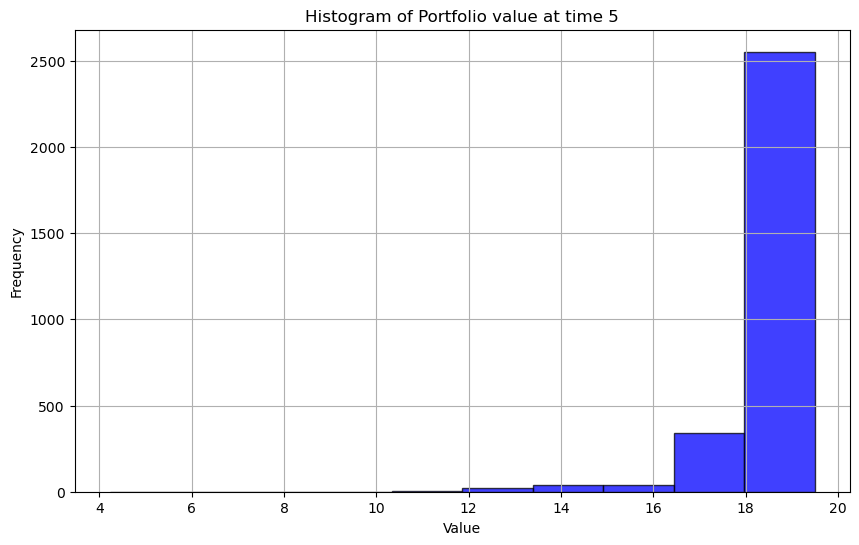

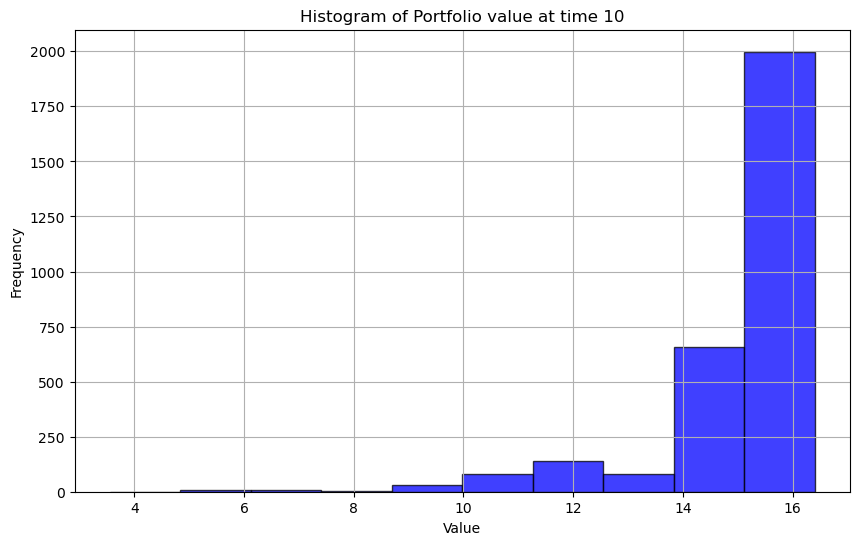

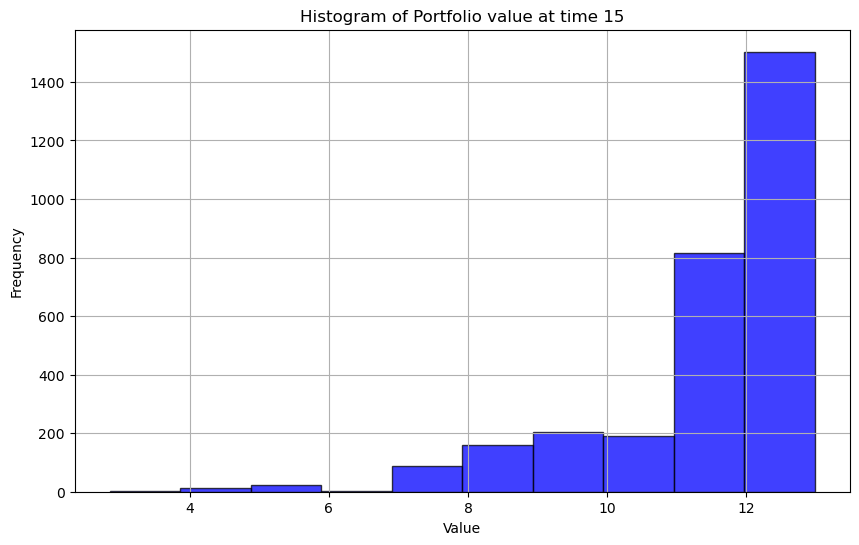

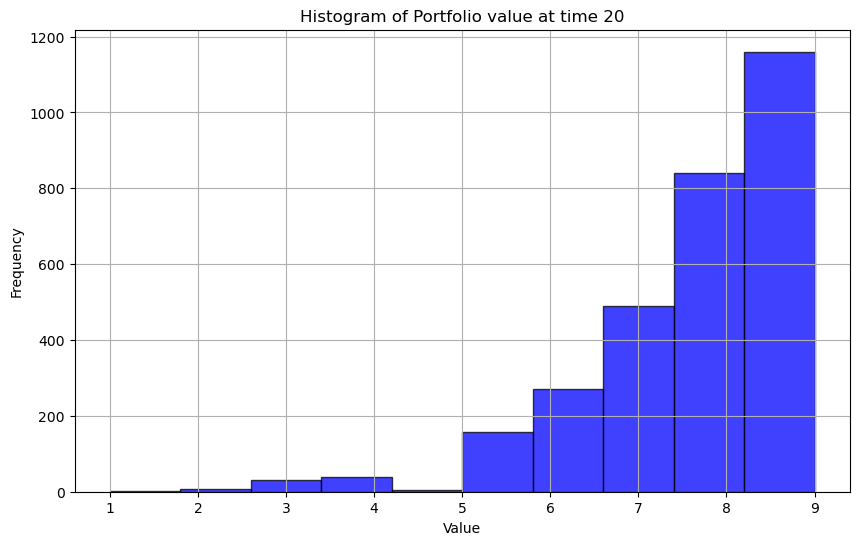

In [10]:
# Number of columns
num_columns = [5, 10, 15, 20]

# Plot histogram for each column
for i in range(len(num_columns)):
    plt.figure(figsize=(10, 6))
    plt.hist(port_value_stack[:, num_columns[i]], bins=10, alpha=0.75, color='blue', edgecolor='black')
    plt.title(f'Histogram of Portfolio value at time {num_columns[i]}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Histograms — Portfolio Value at Selected Horizons

## t = 5
- **Shape:** Very tight, clustered near the upper end; only a faint left tail.  
- **Level/dispersion:** mean = 18.74, σ = 1.23  
- **Tails:** Q05 = 16.82, Q50 = 19.22, Q95 = 19.40  
- **Read:** Early horizon shows almost-certain high values, with minimal downside.

## t = 10
- **Shape:** Distribution shifts left; wider spread with visible left tail (~6–12).  
- **Level/dispersion:** mean = 15.19, σ = 1.65  
- **Tails:** Q05 = 12.29, Q50 = 16.09, Q95 = 16.30  
- **Read:** Mid horizon introduces noticeable downside, though most mass stays 15–16+.

## t = 15
- **Shape:** Clearly broader, heavier left tail (values down to ~3–10); mass around 11–13.  
- **Level/dispersion:** mean = 11.58, σ = 1.69  
- **Tails:** Q05 = 8.44, Q50 = 12.70, Q95 = 12.90  
- **Read:** Downside risk is significant; negative skew dominates.

## t = 20
- **Shape:** Most left-shifted, widest relative dispersion; tail extends to ~2–3.  
- **Level/dispersion:** mean = 7.78, σ = 1.39  
- **Tails:** Q05 = 5.00, Q50 = 8.00, Q95 = 9.00  
- **Read:** Late horizon concentrates between 7–9, with non-trivial risk around 5.

---

## Cross-horizon Takeaway
- **Monotonic decline:** Mean falls ~19 → ~8 as horizon lengthens.  
- **Downside grows faster:** Q05 declines more sharply than the median, showing heavier left tails.  
- **Uncertainty widens:** Early horizons are tightly clustered, while later horizons are spread out and negatively skewed.


## VaR / CVaR from Simulated Portfolio Paths

**Input**
- `port_value_stack ∈ ℝ^{N × (T+1)}`: portfolio **values** for each path (rows) and horizon $t=0,\dots,T$ (columns).

**Definitions (value-based)**
- **VaR** at confidence $\alpha$:  
  $\mathrm{VaR}_\alpha(t) = \text{quantile}_{\,1-\alpha}\!\big(V_t\big)$ — the lower-tail $(1-\alpha)$ quantile of the value distribution.
- **CVaR / ES** at confidence $\alpha$:  
  $\mathrm{CVaR}_\alpha(t) = \mathbb{E}\!\left[\,V_t \mid V_t \le \mathrm{VaR}_\alpha(t)\right]$.

**What the code reports**
- A tidy table indexed by horizon $t$ with columns: `VaR90`, `VaR95`, `VaR99`, and the corresponding `CVaR90`, `CVaR95`, `CVaR99`.
- Computation is **vectorized** across horizons; no loops over $t$ are required.

**Interpretation tips**
- Since this is **value-based VaR**, smaller numbers = worse outcomes (left tail).  
  Typically, $\mathrm{VaR}_{99\%}(t) \le \mathrm{VaR}_{95\%}(t) \le \mathrm{VaR}_{90\%}(t) \le \text{median}(V_t) \le \mathbb{E}[V_t]$.
- If you prefer **loss-based** risk: define $L_t = V_0 - V_t$ (or pathwise P&L) and compute VaR/CVaR on $L_t$ instead.

**Sanity checks**
- Quantile monotonicity across $\alpha$ holds (99% ≤ 95% ≤ 90% for values).  
- Sample size $N$ affects tail stability; increase $N$ for smoother VaR/CVaR at extreme tails.


In [11]:
# === VaR / CVaR from simulated portfolio values ===
def var_matrix(values, levels=(0.90, 0.95, 0.99)):
    """
    values: array-like (n_sims, n_horizons+1) of portfolio VALUES
    Returns: DataFrame with columns VaR90, VaR95, VaR99 (lower-tail quantiles).
    """
    v = np.asarray(values)
    if v.ndim != 2:
        raise ValueError("Expected 2D array: (n_sims, n_horizons+1).")
    out = {}
    for a in levels:
        out[f"VaR{int(a*100)}"] = np.quantile(v, 1.0 - a, axis=0)
    return pd.DataFrame(out)

def cvar_matrix(values, levels=(0.90, 0.95, 0.99)):
    """
    CVaR/ES: average of values at or below the VaR threshold for each horizon.
    """
    v = np.asarray(values)
    n = v.shape[0]
    out = {}
    for a in levels:
        q = np.quantile(v, 1.0 - a, axis=0)
        # broadcast mask per horizon
        mask = v <= q
        # avoid division by zero
        counts = mask.sum(axis=0).clip(min=1)
        out[f"CVaR{int(a*100)}"] = (v * mask).sum(axis=0) / counts
    return pd.DataFrame(out)

# Compute and display
var_df  = var_matrix(port_value_stack, levels=(0.90, 0.95, 0.99))
cvar_df = cvar_matrix(port_value_stack, levels=(0.90, 0.95, 0.99))

summary_vr = pd.concat([var_df, cvar_df], axis=1)
print("VaR / CVaR by horizon (rows = t = 0..T):")
print(summary_vr.round(4).to_string())


VaR / CVaR by horizon (rows = t = 0..T):
      VaR90    VaR95    VaR99   CVaR90   CVaR95   CVaR99
0   22.0461  22.0461  22.0461  22.0461  22.0461  22.0461
1   21.3975  21.3057  19.0905  20.7114  19.9834  18.0049
2   20.7478  18.8476  18.2192  19.3473  18.1268  16.2679
3   20.0934  18.0922  15.8311  18.0097  17.1340  14.7878
4   17.7002  17.4912  15.2766  16.8084  16.0366  13.2668
5   17.0620  16.8787  13.4904  15.9158  14.8262  11.7325
6   16.4624  14.7008  12.3497  14.9315  13.5189  10.9317
7   15.8795  13.9905  11.8867  13.9993  12.7285   9.9550
8   15.2698  13.4470  11.3927  13.0645  11.9655   9.2206
9   14.5207  12.8954   9.6117  12.0217  10.9532   8.2444
10  12.6069  12.3447   8.9591  11.3038  10.1216   7.6030
11  12.0375  10.4117   8.5289  10.5800   9.3155   7.0699
12  11.4883   9.9030   8.1417   9.8760   8.6673   6.4897
13  10.9412   9.4182   7.7410   9.1800   8.0562   5.8568
14  10.3959   8.9308   6.3723   8.4659   7.4549   5.2726
15   9.8135   8.4451   5.6787   7.6713   6.7394

## VaR / CVaR — Concise Readout

**Value-based risk by horizon (t = 0…20):**
- $\mathrm{VaR}_{90}$ falls **22.05 → 6.00**  
- $\mathrm{VaR}_{95}$ falls **22.05 → 5.00**  
- $\mathrm{VaR}_{99}$ falls **22.05 → 3.00**  
- $\mathrm{CVaR}_{99}$ (tail average) falls **22.05 → 2.76**

**Milestones**
- $\mathrm{VaR}_{95} < 10$ by **t ≈ 12**  
- $\mathrm{VaR}_{99} < 6$ by **t ≈ 15**  
- By **t = 20**: $(\mathrm{Mean}, \mathrm{VaR}_{95}, \mathrm{VaR}_{99}, \mathrm{CVaR}_{99}) \approx (7.78,\ 5.00,\ 3.00,\ 2.76)$

**Interpretation**
- Risk **monotonically increases** with horizon: left-tail protection erodes steadily.  
- Extreme-tail outcomes ($99\%$) collapse to around **3** by maturity.  
- Always $\mathrm{CVaR}_\alpha < \mathrm{VaR}_\alpha$ — showing **heavier losses inside the tail**.  
- Early horizons remain near initial value, but downside spreads widen rapidly mid-to-late horizons, consistent with **cumulative default/discounting effects**.
